In [1]:
import pickle
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from utils import ProgressBar,Dataset
import pickle
plt.style.use('ggplot')
%matplotlib inline

# english subword

In [2]:
from __future__ import unicode_literals

import sys
import codecs
import re
import copy
import argparse
from collections import defaultdict, Counter

# hack for python2/3 compatibility
from io import open
argparse.open = open

def get_vocabulary(fobj, is_dict=False):
    """Read text and return dictionary that encodes vocabulary
    """
    vocab = Counter()
    for line in fobj:
        if is_dict:
            word, count = line.strip().split()
            vocab[word] = int(count)
        else:
            for word in line.split():
                vocab[word] += 1
    return vocab

def update_pair_statistics(pair, changed, stats, indices):
    """Minimally update the indices and frequency of symbol pairs
    if we merge a pair of symbols, only pairs that overlap with occurrences
    of this pair are affected, and need to be updated.
    """
    stats[pair] = 0
    indices[pair] = defaultdict(int)
    first, second = pair
    new_pair = first+second
    for j, word, old_word, freq in changed:

        # find all instances of pair, and update frequency/indices around it
        i = 0
        while True:
            # find first symbol
            try:
                i = old_word.index(first, i)
            except ValueError:
                break
            # if first symbol is followed by second symbol, we've found an occurrence of pair (old_word[i:i+2])
            if i < len(old_word)-1 and old_word[i+1] == second:
                # assuming a symbol sequence "A B C", if "B C" is merged, reduce the frequency of "A B"
                if i:
                    prev = old_word[i-1:i+1]
                    stats[prev] -= freq
                    indices[prev][j] -= 1
                if i < len(old_word)-2:
                    # assuming a symbol sequence "A B C B", if "B C" is merged, reduce the frequency of "C B".
                    # however, skip this if the sequence is A B C B C, because the frequency of "C B" will be reduced by the previous code block
                    if old_word[i+2] != first or i >= len(old_word)-3 or old_word[i+3] != second:
                        nex = old_word[i+1:i+3]
                        stats[nex] -= freq
                        indices[nex][j] -= 1
                i += 2
            else:
                i += 1

        i = 0
        while True:
            try:
                # find new pair
                i = word.index(new_pair, i)
            except ValueError:
                break
            # assuming a symbol sequence "A BC D", if "B C" is merged, increase the frequency of "A BC"
            if i:
                prev = word[i-1:i+1]
                stats[prev] += freq
                indices[prev][j] += 1
            # assuming a symbol sequence "A BC B", if "B C" is merged, increase the frequency of "BC B"
            # however, if the sequence is A BC BC, skip this step because the count of "BC BC" will be incremented by the previous code block
            if i < len(word)-1 and word[i+1] != new_pair:
                nex = word[i:i+2]
                stats[nex] += freq
                indices[nex][j] += 1
            i += 1


def get_pair_statistics(vocab):
    """Count frequency of all symbol pairs, and create index"""

    # data structure of pair frequencies
    stats = defaultdict(int)

    #index from pairs to words
    indices = defaultdict(lambda: defaultdict(int))

    for i, (word, freq) in enumerate(vocab):
        prev_char = word[0]
        for char in word[1:]:
            stats[prev_char, char] += freq
            indices[prev_char, char][i] += 1
            prev_char = char

    return stats, indices


def replace_pair(pair, vocab, indices):
    """Replace all occurrences of a symbol pair ('A', 'B') with a new symbol 'AB'"""
    first, second = pair
    pair_str = ''.join(pair)
    pair_str = pair_str.replace('\\','\\\\')
    changes = []
    pattern = re.compile(r'(?<!\S)' + re.escape(first + ' ' + second) + r'(?!\S)')
    if sys.version_info < (3, 0):
        iterator = indices[pair].iteritems()
    else:
        iterator = indices[pair].items()
    for j, freq in iterator:
        if freq < 1:
            continue
        word, freq = vocab[j]
        new_word = ' '.join(word)
        new_word = pattern.sub(pair_str, new_word)
        new_word = tuple(new_word.split())

        vocab[j] = (new_word, freq)
        changes.append((j, new_word, word, freq))

    return changes

def prune_stats(stats, big_stats, threshold):
    """Prune statistics dict for efficiency of max()
    The frequency of a symbol pair never increases, so pruning is generally safe
    (until we the most frequent pair is less frequent than a pair we previously pruned)
    big_stats keeps full statistics for when we need to access pruned items
    """
    for item,freq in list(stats.items()):
        if freq < threshold:
            del stats[item]
            if freq < 0:
                big_stats[item] += freq
            else:
                big_stats[item] = freq


def main(infile, outfile, num_symbols, min_frequency=2, verbose=False, is_dict=False):
    """Learn num_symbols BPE operations from vocabulary, and write to outfile.
    """

    # version 0.2 changes the handling of the end-of-word token ('</w>');
    # version numbering allows bckward compatibility
    outfile.write('#version: 0.2\n')

    vocab = get_vocabulary(infile, is_dict)
    vocab = dict([(tuple(x[:-1])+(x[-1]+'</w>',) ,y) for (x,y) in vocab.items()])
    sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

    stats, indices = get_pair_statistics(sorted_vocab)
    big_stats = copy.deepcopy(stats)
    # threshold is inspired by Zipfian assumption, but should only affect speed
    threshold = max(stats.values()) / 10
    for i in range(num_symbols):
        if stats:
            most_frequent = max(stats, key=lambda x: (stats[x], x))

        # we probably missed the best pair because of pruning; go back to full statistics
        if not stats or (i and stats[most_frequent] < threshold):
            prune_stats(stats, big_stats, threshold)
            stats = copy.deepcopy(big_stats)
            most_frequent = max(stats, key=lambda x: (stats[x], x))
            # threshold is inspired by Zipfian assumption, but should only affect speed
            threshold = stats[most_frequent] * i/(i+10000.0)
            prune_stats(stats, big_stats, threshold)

        if stats[most_frequent] < min_frequency:
            sys.stderr.write('no pair has frequency >= {0}. Stopping\n'.format(min_frequency))
            break

        if verbose:
            sys.stderr.write('pair {0}: {1} {2} -> {1}{2} (frequency {3})\n'.format(i, most_frequent[0], most_frequent[1], stats[most_frequent]))
        outfile.write('{0} {1}\n'.format(*most_frequent))
        changes = replace_pair(most_frequent, sorted_vocab, indices)
        update_pair_statistics(most_frequent, changes, stats, indices)
        stats[most_frequent] = 0
        if not i % 100:
            prune_stats(stats, big_stats, threshold)


# process real data

In [17]:
sentence_len = 50
english_words = 130000
chinese_words = 120000

In [18]:
en_words = list(map(lambda x:(x.split('\t')[0],int(x.split('\t')[1])), open('middleresult/en_vocab.txt',encoding='utf-8').read().split('\n')[:-1]))
zh_words = list(map(lambda x:(x.split('\t')[0],int(x.split('\t')[1])), open('middleresult/zh_vocab.txt',encoding='utf-8').read().split('\n')[:-1]))

In [19]:
from utils import ProgressBar,Dataset

In [20]:
vocab = dict(map(lambda x:('_' + x[0],x[1]),en_words))
#vocab = dict([(tuple(x[:-1])+(x[-1]+'</w>',) ,y) for (x,y) in vocab.items()])
vocab = dict([(tuple(x[:-1])+(x[-1],) ,y) for (x,y) in vocab.items()])
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

stats, indices = get_pair_statistics(sorted_vocab)
big_stats = copy.deepcopy(stats)
# threshold is inspired by Zipfian assumption, but should only affect speed
threshold = max(stats.values()) / 10


In [21]:
num_symbols = 100000
min_frequency=2
verbose = False
pb = ProgressBar(worksum=num_symbols)
pb.startjob()

for i in range(num_symbols):
    if stats:
        most_frequent = max(stats, key=lambda x: (stats[x], x))

    # we probably missed the best pair because of pruning; go back to full statistics
    if not stats or (i and stats[most_frequent] < threshold):
        prune_stats(stats, big_stats, threshold)
        stats = copy.deepcopy(big_stats)
        most_frequent = max(stats, key=lambda x: (stats[x], x))
        # threshold is inspired by Zipfian assumption, but should only affect speed
        threshold = stats[most_frequent] * i/(i+10000.0)
        prune_stats(stats, big_stats, threshold)

    if stats[most_frequent] < min_frequency:
        sys.stderr.write('no pair has frequency >= {0}. Stopping\n'.format(min_frequency))
        break

    if verbose:
        sys.stderr.write('pair {0}: {1} {2} -> {1}{2} (frequency {3})\n'.format(i, most_frequent[0], most_frequent[1], stats[most_frequent]))
    #outfile.write('{0} {1}\n'.format(*most_frequent))
    changes = replace_pair(most_frequent, sorted_vocab, indices)
    update_pair_statistics(most_frequent, changes, stats, indices)
    stats[most_frequent] = 0
    if not i % 100:
        prune_stats(stats, big_stats, threshold)
    pb.info = 'pair {0}: {1} {2} -> {1}{2} (frequency {3}) '.format(i, most_frequent[0], most_frequent[1], stats[most_frequent])
    pb.complete(1)


pair 99999: if al -> ifal (frequency 0)  100.00 % [==================================================>] 100000/100000 	 used:756s eta:0 s

In [22]:
allpieces = []
for i in [i[0] for i in sorted_vocab]:
    for j in i:
        allpieces.append(j)

In [23]:
len(set(allpieces))

98522

In [24]:
segmented_frame = pd.DataFrame(
    {'origin':list(
    map(lambda x:''.join(x[0])[1:],
        sorted(vocab.items(), key=lambda x: x[1], reverse=True))
    )
     ,'segmented':[i[0] for i in sorted_vocab]
     })

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012F03C97C50>]], dtype=object)

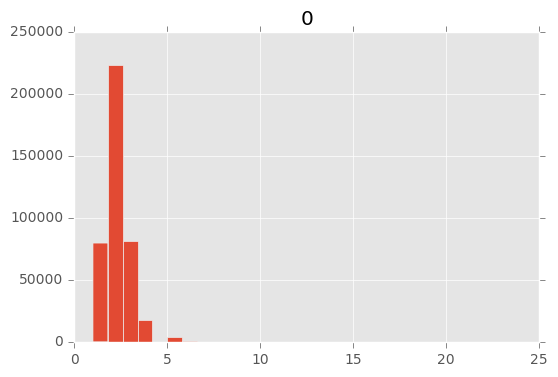

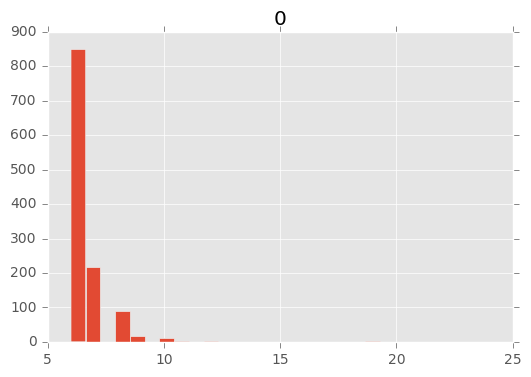

In [26]:
pd.DataFrame([len(i[0]) for i in sorted_vocab]).hist(bins=30)

pd.DataFrame([len(i[0]) for i in sorted_vocab if len(i[0]) > 5]).hist(bins=30)

In [147]:
!mkdir data
!mkdir data/preprocessing_subword

mkdir: cannot create directory ‘data’: File exists


In [27]:
with open('data/preprocessing_subword/subwords_allwords_full100000.en','wb') as whdl:
    pickle.dump({'origin':list(
        map(lambda x:''.join(x[0])[1:],
            sorted(vocab.items(), key=lambda x: x[1], reverse=True))
            )
            ,'segmented':[i[0] for i in sorted_vocab]
            ,'subwords':set(allpieces)
         },whdl)